In [1]:
import torch
import cv2

import glob
import pandas as pd
import numpy as np
import os

import config
import utils

from torch.utils.data import Dataset, DataLoader


Using mps device


In [2]:
class CoronarographyDataset(Dataset):
    def __init__(self, dir_path, annotations_file, classes, transforms=None, custom_transforms=None):
        self.dir_path = dir_path
        self.classes = classes
        self.transforms = transforms
        self.custom_transforms = custom_transforms

        # read .csv file with the image annotations
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_annotations = self.img_annotations.sort_values(by=['filename']).reset_index(drop=True)
        # get all the image paths from 'filename' column in sorted order
        self.image_paths = self.img_annotations['filename'].unique()
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]

    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # extract bounding box from annotation file
        bboxes, labels = [], []
        annotations = self.img_annotations[self.img_annotations['filename'] == image_name]
        for idx_i in range(len(annotations)):
            bbox = annotations.iloc[idx_i, 4:].values.astype(int)
            bbox = np.array(bbox, dtype=int)
            bboxes.append(bbox)
            labels.append([1])
        bboxes = np.array(bboxes, dtype=int) 
        
        # read the image
        image = cv2.imread(image_path)

        # apply custom transforms(resize, remove borders)
        if self.custom_transforms:
            image, bboxes = self.custom_transforms(image, bboxes)

        # bounding box to tensor
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        # no crowd instances
        is_crowd = torch.zeros((bboxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = bboxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = is_crowd
        target["image_id"] = torch.tensor([idx])

        # apply augmentation
        if self.transforms:
            sample = self.transforms(image = image,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image, target

In [3]:
class RemoveBorder(object):
    """
    Cuts black frame of the image. In case of incorrect border detection,
    default values are used to crop the border.
    """
    def __init__(self, max_cut=.2, default_cut=60):
        assert isinstance(default_cut, int)
        self.max_cut = max_cut
        self.default_cut = default_cut
    
    def __call__(self, image, bboxes):
        # crop borders
        nx, ny, ndx, ndy = utils.cut_frame(image, self.max_cut, self.default_cut)
        image_cropped = image[nx:ndx, ny:ndy]
        
        # calculate new coordinates of bboxes
        bboxes_cropped = []
        for bbox in bboxes:
            x, y, dx, dy = bbox
            bbox_nx, bbox_ny = x - nx, y - ny
            bbox_ndx, bbox_ndy = dx - nx, dy - ny
            bboxes_cropped.append([bbox_nx, bbox_ny, bbox_ndx, bbox_ndy])

        if any(bboxes_cropped) < 0:
            print("Negative index of bbox after cropping. Original image was used.")
            return image, bboxes

        return image_cropped, bboxes_cropped


class Resize(object):
    """
    Rescale the image in a sample to a given size. Width and height are kept the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, image, bboxes):
        H, W, _ = image.shape
        H_scaled, W_scaled = self.output_size /  H, self.output_size / W
    
        # resize image and bboxes
        image_resized = cv2.resize(image, (self.output_size, self.output_size))
        bboxes_resized = []
        for bbox in bboxes:
            x, y, dx, dy = bbox
            nx = int(np.round(x * W_scaled))
            ny = int(np.round(y * H_scaled))
            ndx = int(np.round(dx * W_scaled))
            ndy = int(np.round(dy * H_scaled))
            bboxes_resized.append([nx, ny, ndx, ndy])
        
        return image_resized, bboxes_resized


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, bboxes):
        for t in self.transforms:
            image, bboxes = t(image, bboxes)
        return image, bboxes

def get_train_custom_transform():
    return Compose([
        Resize(config.RESIZE_TO),
        RemoveBorder(max_cut=.1, default_cut=40),
    ])

In [4]:
transformed_dataset = CoronarographyDataset(
    dir_path=config.DATASET_DIR, 
    annotations_file=config.TRAIN_ANNOTATION, 
    classes=config.CLASSES,
    custom_transforms=get_train_custom_transform()
)

In [38]:
# transformed_dataset[1]

To improve the robustness of the CNN model, several data augmentation techniques, including 
- random rotation,
- scaling,
- Gaussian noise transform,
- Gaussian blur transform,
- brightness multiplicative transform and
- elastic deform,

were applied to increase the sample size.

In [33]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_train_transform():
    return A.Compose([
        A.CropAndPad(
            pad_mode=cv2.BORDER_REPLICATE, percent=(0.0, 0.05), 
            sample_independently=True, keep_size=True, p=0.5,
            interpolation=cv2.INTER_CUBIC
        ),
        A.Rotate(limit=30, p=0.5),
        A.GaussNoise(var_limit=(0, 30), p=0.5),
        A.GaussianBlur(p=0.5),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5
        ),
        # A.ElasticTransform(p=0.5),
        # ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'min_visibility': 0.8,
        'label_fields': ['labels']
    })
    
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [34]:
train_dataset = CoronarographyDataset(
    config.DATASET_DIR, 
    config.TRAIN_ANNOTATION, 
    config.CLASSES, 
    custom_transforms = get_train_custom_transform(),
    transforms=get_train_transform()
)

In [35]:
dataset = CoronarographyDataset(
    config.DATASET_DIR, 
    config.TRAIN_ANNOTATION, 
    config.CLASSES, 
    custom_transforms= Compose([
        Resize(config.RESIZE_TO)
    ])
)

In [36]:
# dataset[1]

In [37]:
import matplotlib.pyplot as plt

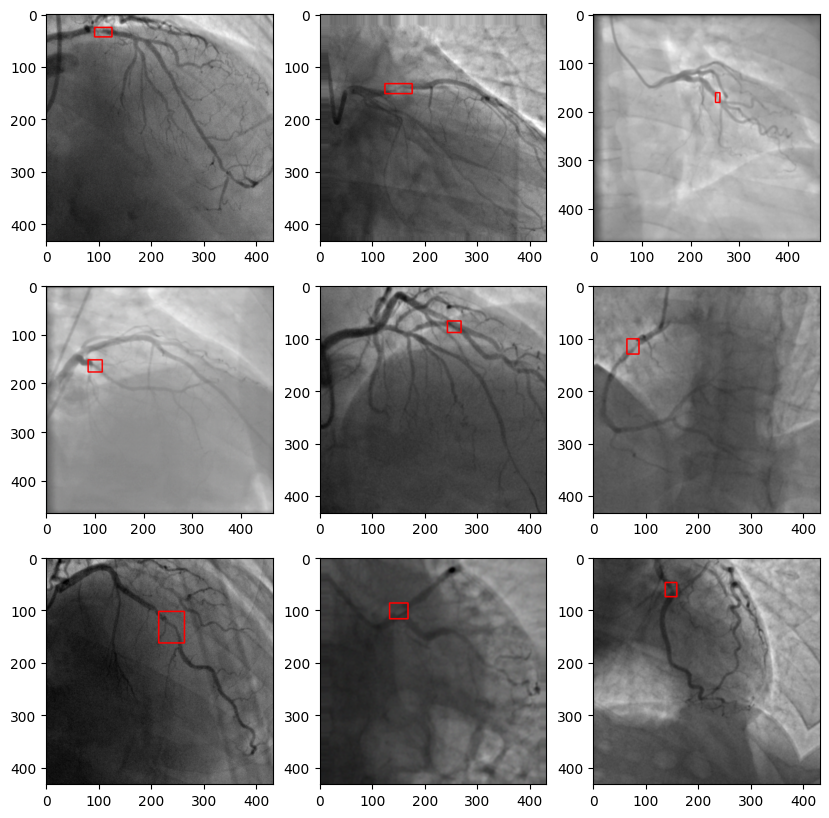

In [38]:
NUM_SAMPLES_TO_VISUALIZE = 9
cols = 3
rows = int(np.ceil(NUM_SAMPLES_TO_VISUALIZE / cols))

fig = plt.figure(figsize=(10, 10))
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    img_idx = np.random.randint(0, len(train_dataset))
    image, target = train_dataset[img_idx]
    fig.add_subplot(rows, cols, i+1)
    for box_num in range(len(target['boxes'])):
        box = target['boxes'][box_num]
        label = config.CLASSES[target['labels'][box_num]]
        cv2.rectangle(
            image, 
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (255, 0, 0), 2
        )
    plt.imshow(image)
plt.show()

***

In [ ]:
def create_train_dataset():
    train_dataset = CustomDataset(config.DATASET_DIR, config.TRAIN_ANNOTATION, config.RESIZE_TO, config.RESIZE_TO, config.CLASSES, None, utils.custom_transform())
    return train_dataset
    
def create_valid_dataset():
    valid_dataset = CustomDatasetconfig.DATASET_DIR, config.TRAIN_ANNOTATION, config.RESIZE_TO, config.RESIZE_TO, config.CLASSES)
    return valid_dataset

In [49]:
ds = CoronarographyDataset(config.DATASET_DIR, config.TRAIN_ANNOTATION, config.RESIZE_TO, config.RESIZE_TO, config.CLASSES)

In [50]:
tmp = ds.img_annotations

In [58]:
bboxes = []
for idx in tmp[tmp.filename == '14_002_5_0017.bmp'].index:
    bbox = tmp.iloc[idx, 4:].values.astype(int)
    bbox = np.array(bbox, dtype=int)
    bboxes.append(bbox)
bboxes = np.array(bboxes, dtype=int)

In [59]:
bboxes

array([[161, 173, 179, 187],
       [222, 174, 241, 186]])

In [60]:
area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])

In [61]:
area

array([252, 228])

In [62]:
torch.zeros((bboxes.shape[0],), dtype=torch.int64)

tensor([0, 0])